# Discrete Distributions II
DA Probability & Statistics Learning Series • 📚.4.1


<br>
<img src="https://i.imgflip.com/l338f.jpg" width=400 />
<br>


Welcome!

*See **#da_learn_develop** for discussion during and after this tutorial.*

### Goals

- Practice using **expectation**, **indicator random variables**, and **counting** 😱.
- Introduce **variance** and lay the groundwork for generalizing it across all \[discrete\] distributions.
- See how we can calculate the **expectation of functions/transformations of random variables** using the **law of the unconscious statistician** (LOTUS).
- Acquaint ourselves with the **Geometric** distribution and see how we can use it to **model survival probabilities**.
- Introduce the **Poisson** and establish its relationship with the distributions based on Bernoulli processes.


*We will break this session into multiple parts depending on how far we get given our time constraints.*

In [1]:
# Autoreload changes to custom
%load_ext autoreload
%autoreload 2

# Sharpen matplotlib plots
%config InlineBackend.figure_format = 'retina'

In [2]:
# Import dependencies 
from custom.db_utils import get_connection
import pandas as pd

# Analysis
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
from scipy.stats import geom
from scipy.optimize import minimize_scalar
import numpy as np

# Data viz
from custom.viz_utils import plot_step, plot_distribution
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator, MultipleLocator
from matplotlib.patches import Rectangle

# Global plot settings
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Warm Up 🤔

It's been awhile since we've had to think about our 📚 material, so let's jog the nog':

**Question**:

> What's the "story" of the Hypergeometric?

**Hint 1**: What are *parameters* of a distribution? Give an example.

**Hint 2**: What does the Binomial count, i.e., what is its story?

**Answer**:

> The Hypergeometric is parameterized by three values (e.g., $w$, $b$, and $n$). The distribution counts how many white balls I get from drawing $n$ balls *without* replacement from a jar filled with $w$ white balls and $b$ black balls.

More generally, **the Hypergeometric is apt when two categorical 'tags' (or features) describe your data**. This is useful for hypothesis testing like **Fischer's Exact Test** and (as we'll see later) the **Log Rank Test** (in the context of survival analysis).

- "How many tagged elk will I have when I recapture $n$ elk from a forest in which I had tagged $w$ elk and  left $b$ untagged?"

- "Of $w$ soup lunches and $b$ non-soup lunches, how many of $n$ Christy's lunches consisted of soup?"

- "[Can a lady determine whether milk is added before or after tea is poured?](https://en.wikipedia.org/wiki/Muriel_Bristol)"

- "Does COVID-19 adversely affect men vs. women differently?"

## Expectation & Indicator R.V.s, redux 🔙

**Question**:

> Let $X \sim \text{HGeom}(w, b, n)$. What is $\mathbb{E}(X)$?

**Hint 1**: Let's use wishful thinking -- what's the expectation of the Binomial?

**Hint 2**: $p$ in the Binomial is fixed because we sample with replacement. What if we keep the form of $np$ but just redefine $p$ for the Hypergeometric?

**Hint 3**: Use indicator random variables (r.v.s)!

**Answer**:

> $\mathbb{E}(X) = n\frac{w}{w+b}$. Notice how this aligns nicely with the expectation of the Binomial!

## Variance 🆕

Alas, we have arrived at **variance**. I think this term is "overloaded" in machine learning and statistics because how it is used often fails to make explicit what is being measured.

Just as expectation **compresses all the information of our data into one number** to measure central tendency (or, intuitively, what we should expect to see removing effects of noise), **variance** attempts to do the same thing, but in terms of **the dispersion or "spread" of our data.**

**Question**: 

> How might you define a measure of "spread" of your data?

**Answer**:

> There isn't one "absolutely correct" way! You might have proposed the following:

> "What's the average distance (in absolute value) of our data from its mean?" 

$$
\frac{1}{n}\sum_{i}\left|x_{i} - \bar{x}\right|
$$

> "What's the squared deviation of our data from its mean?"

$$
\frac{1}{n-1}\sum_{i}\left(x_{i} - \bar{x}\right)^{2}
$$

### Aside: Notation, meet Philosophy

So, you've probably already noticed that the notation looks different! This is a subtle but very important distinction to keep in mind: **we live and work in the world of *observed data*** which is merely a reflection of **the world of *data-generating* processes**.

Roughly, the enterprise of **probability starts with the latter and attempts to make claims about the former**, whereas the work undertaken by **statistics is the opposite**.

Going back to our measures of dispersion, when we compute these...

$$
\frac{1}{n}\sum_{i}\left|x_{i} - \bar{x}\right|
$$

$$
\frac{1}{n-1}\sum_{i}\left(x_{i} - \bar{x}\right)^{2}
$$

We are actually *estimating* these...

$$
\mathbb{E}\left|X  - \mathbb{E}X \right|
$$

$$
\mathbb{E}\left(X  - \mathbb{E}X \right)^{2}
$$

Notice the parallelism between the two!

In fact, when we are talking about things like **mean squared error** (MSE) as a loss function that we want to minimize in order to find a model (e.g., 🐍.4) that generalizes well to unseen data, we will treat the model $\hat{f}(\mathbf{x})$ itself as a *random variable* which will allow us to conceptually make sense how much of the error or loss is due to **variance** vs. **bias** (i.e., the simplest form of the **bias-variance tradeoff**).


$$
\text{MSE} = E_{\mathbf{x}} \left\{ \text{Bias}_{\mathcal{D}} \left[\hat{f}(\mathbf{x}|\mathcal{D}) \right]^{2} + \text{Var}_{\mathcal{D}} \left[\hat{f}(\mathbf{x}|\mathcal{D}) \right] + \sigma^{2} \right\}
$$

*This looks scary. It's won't be once we get a few more tools under our belt.*

Let's play with this definition of $\text{Var}(X)$ to see if we discover anything interesting.


$$
\begin{align}
\text{Var}(X) &= \mathbb{E}\left(X  - \mathbb{E}X \right)^{2}\\
&= \mathbb{E}\left((X  - \mathbb{E}X)(X  - \mathbb{E}X) \right)\\
&= \mathbb{E}\left(X^{2}  - 2X\mathbb{E}X + \mathbb{E}(X)^{2} \right)\\
&= \mathbb{E}(X^{2}) - \mathbb{E}(2X\mathbb{E}X) + \mathbb{E}(\mathbb{E}(X)^{2})\\
&= \mathbb{E}(X^{2}) - 2\mathbb{E}(X\mathbb{E}X) + \mathbb{E}(X)^{2}\\
&= \mathbb{E}(X^{2}) - \mathbb{E}(X\mathbb{E}X) - \mathbb{E}(X\mathbb{E}X) + \mathbb{E}(X)^{2}\\
&= \mathbb{E}(X^{2}) - \mathbb{E}X\mathbb{E}X - \mathbb{E}X\mathbb{E}X + \mathbb{E}(X)^{2}\\
&= \mathbb{E}(X^{2}) - 2\mathbb{E}(X)^{2} + \mathbb{E}(X)^{2}\\
&= \mathbb{E}(X^{2}) - \mathbb{E}(X)^{2}\\
\end{align}
$$

This seems like a silly exercise, but let's take a look at what this is telling us in couple of ways.

![Expectation Intuition](https://images.squarespace-cdn.com/content/v1/54e50c15e4b058fc6806d068/1424477383098-CKRS6U6AJHE1B1NJAA30/ke17ZwdGBToddI8pDm48kFudF1WMv5_yboat0laVeH1Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZamWLI2zvYWH8K3-s_4yszcp2ryTI0HqTOaaUohrI8PIk7bNhZ_LMVNnJlw8hf_hEdzLHiugbuXNhtkdaRrh4HY/image-asset.png?format=1500w)

Recall what Shore and I have been saying since 📚.3.1: **random variables** are *functions* that map events to $\mathbb{R}$ (later we'll generalize this definition even more). 

For example, we see that this mental model (for discrete distributions) from above is described perfectly by the mathematical definition:

$$
E(X) = \sum x f(x)\, \text{where $f(x) = P(X=x)$ is the PMF of $X$}
$$

![Variance Intuition](https://images.squarespace-cdn.com/content/v1/54e50c15e4b058fc6806d068/1424594885892-3PYKW0ERG0NXYWAO2Y6H/ke17ZwdGBToddI8pDm48kF_pzlkkltdkpEL0RXt_nBcUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYxCRW4BPu10St3TBAUQYVKcIaUsDTFXMDfrbaMeXUWyV0nvgwPWOUTnane6m2nEm3VzaIqIKYWc3eiLl8aS5TDC/robot-variance-visualization.png?format=1500w)

One way of looking at variance is the difference of squaring our random variable at different points when we calculate expectation:

$$
\text{Var}(X) = \mathbb{E}(X^{2}) - \mathbb{E}(X)^{2}\\
$$


**Source**: [Count Bayesie](https://www.countbayesie.com/). "Understanding Variance, Covariance, and Correlation" 2015 March 03.

#### Visualizing Variance

Let's start by sampling some data from a distribution (the **Geometric**) that we'll soon introduce with all of the usual pageantry of story, intuition, examples, etc.

Data: [ 3  2  7  0  6  4  3 15  1  0]
Mean: 4.1


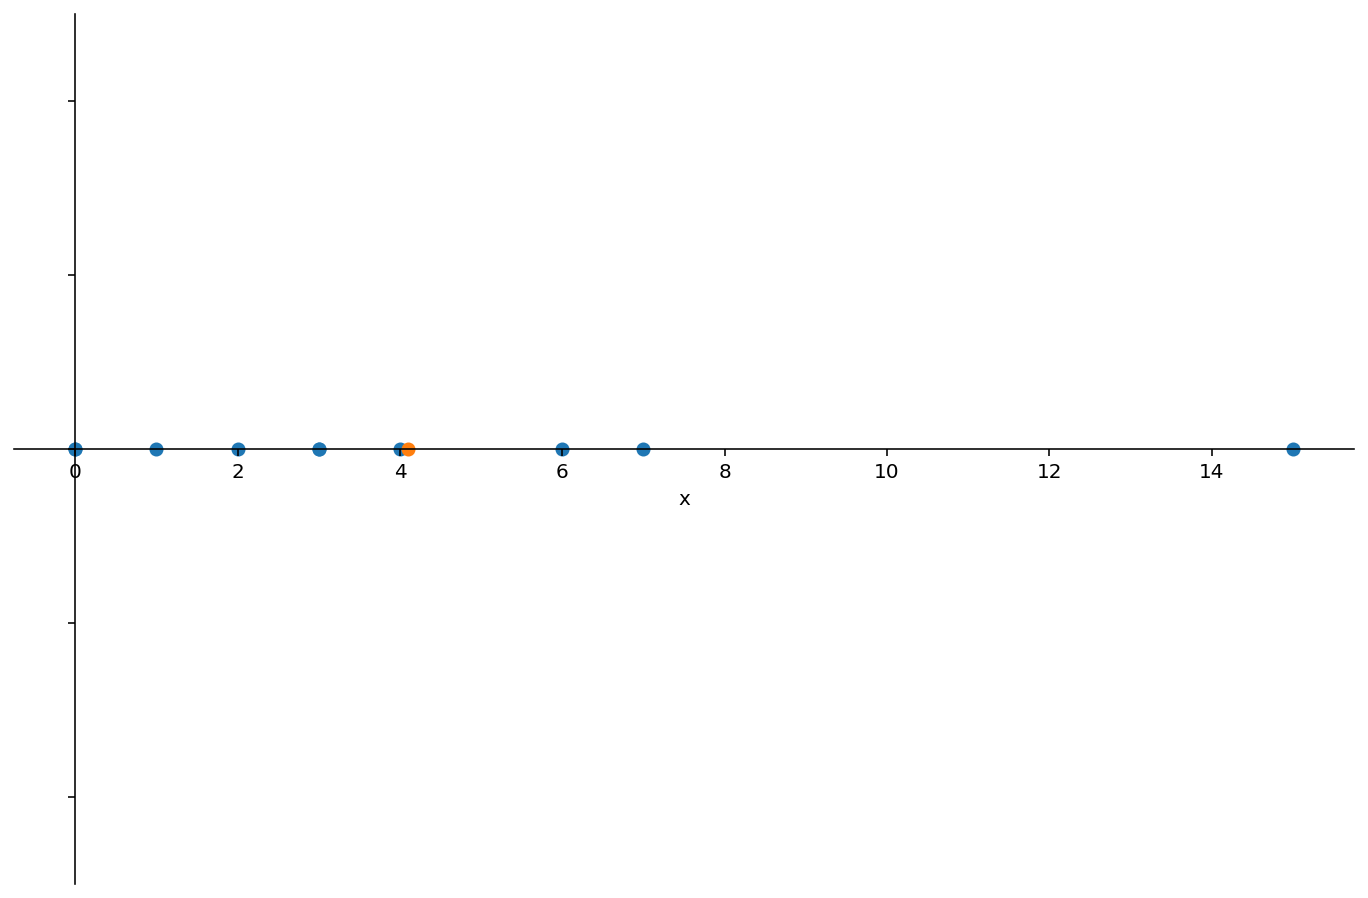

In [3]:
# Parameterize example geometric distribution
p = 0.25

# Random variable X is distributed Geom(p)
x = geom.rvs(p, loc=-1, size=10, random_state=18)
print('Data:', x)
print('Mean:', x.mean())

# Plot data
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(x, np.zeros_like(x))
plt.scatter(x.mean(), 0)

plt.xlabel('x')
plt.ylim(bottom=-.05, top=.05)

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.set_yticklabels([])

plt.show()

Now, let's get the *squared differences from the mean*:

Data: [ 3  2  7  0  6  4  3 15  1  0]
Mean: 4.1
(Biased estimate of) Variance: 18.1
(Unbiased estimate of) Variance: 20.1
Population Variance: 12.0


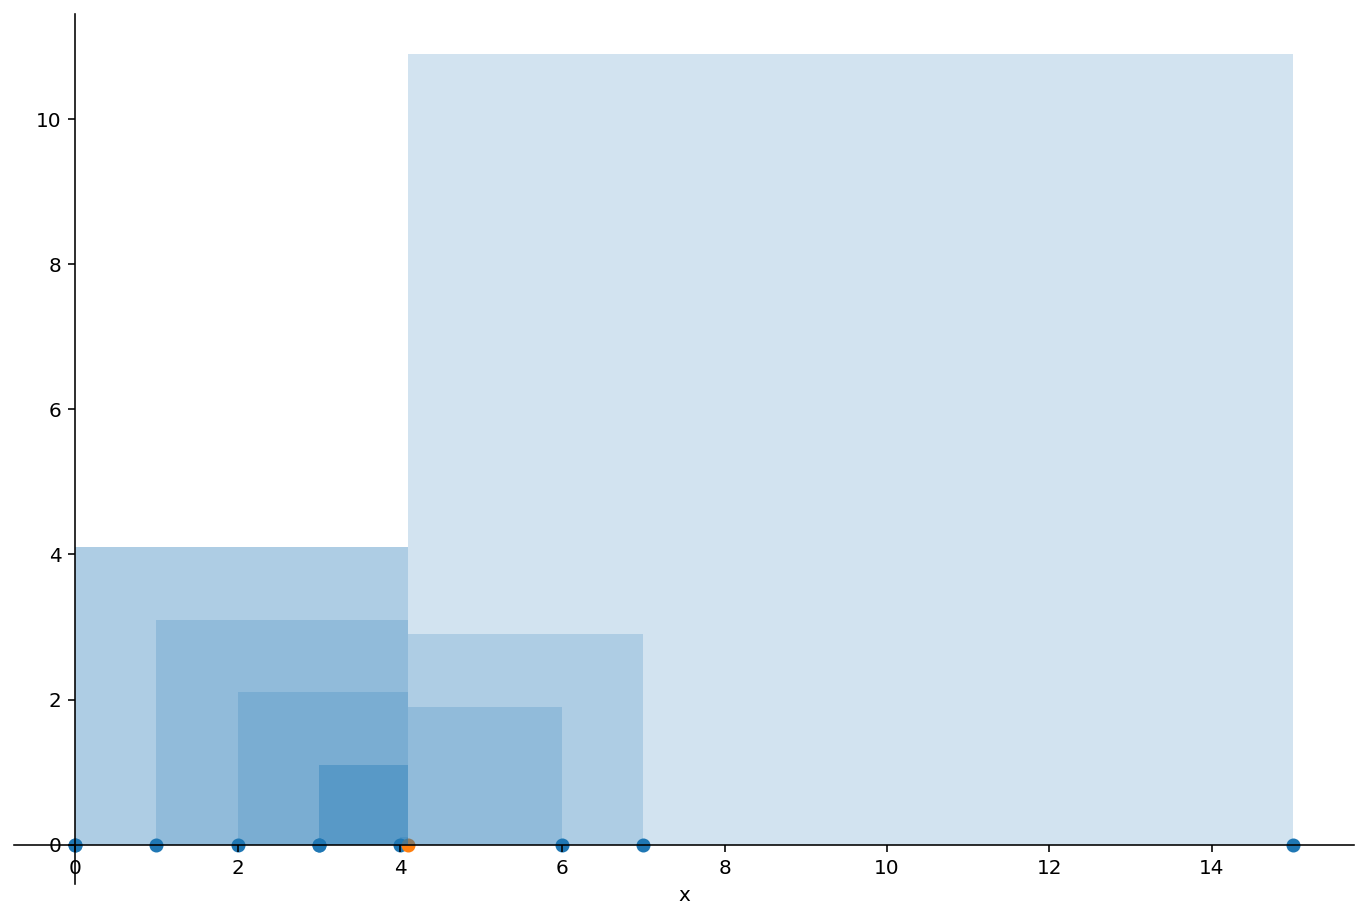

In [4]:
# Calculated differences from the mean
x_sq_diff = (x - x.mean())**2
x_abs_diff = np.abs(x - x.mean())

# Plot data
print('Data:', x)
print('Mean:', x.mean())
print(f"(Biased estimate of) Variance: {x_sq_diff.mean():.1f}")
print(f"(Unbiased estimate of) Variance: {x.var(ddof=1):.1f}") 
print(f"Population Variance: {(1-p) / p**2:.1f}") 

plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(x, np.zeros_like(x))
plt.scatter(x.mean(), 0)

ax = plt.gca()

patches = []
for i, x_i in enumerate(x):
    xy_i = (min(x.mean(), x_i), 0)
    sq = Rectangle(xy=xy_i, width=x_abs_diff[i], height=x_abs_diff[i], alpha=0.2)
    ax.add_patch(sq)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
plt.xlabel('x')

plt.show()


**Check**: When is variance zero? Can variance be negative?

Notice that the squared measure accentuates the impact of extreme values.

**Question**: 

> Do we have everything we need to evaluate $\text{Var}(X)$ for any discrete random variable $X$?

$$
\text{Var}(X) = \mathbb{E}(X^{2}) - \mathbb{E}(X)^{2}\\
$$

**Answer**:

> Not yet: we don't have a way of calculating the expectation for a non-linear *function* of a random variable!

But wait. A random variable is a function. What's a function of a random variable?

A **function of a random variable** is a **random variable**! 

**Question**: 

> So, how might we evaluate $E(X^{2})$?

**Hint 1**: What is the definition of expectation?

**Hint 2**: Use the "wishful thinking" problem solving strategy.

## Law of the Unconscious Statistican (LOTUS) 𑁍

Remember, we when we have a *linear* function of a random variable, say $2X + 6$, we can use **linearity of expectation** to put everything in terms of $E(X)$:

$$
\mathbb{E}(2X + 6) = \mathbb{E}(2X) + \mathbb{E}(6) = 2\mathbb{E}(X) + 6
$$

Now, let's turn our attention to the one piece of the definition of variance for which we have yet to figure out: $E(X^{2})$.

It would be a **massive mistake** to assume that $E(X^{2}) = E(X)^{2}$. First of all, this would mean **variance** is *always zero*, which we know not to be true. 

$$
\text{Var}(X) = \mathbb{E}(X^{2}) - \mathbb{E}(X)^{2} \,\,\,\not\!\!\!\!\implies \mathbb{E}(X)^{2} - \mathbb{E}(X)^{2} = 0
$$

Also, we can verify this by a small simulation:

In [5]:
# Generate some data from a standard normal and transform it
y = np.random.normal(size=1_000_000)
y_sq = y ** 2

print("Estimated Mean of X:", y.mean())
print("Estimated Mean of X^2:", y_sq.mean())

Estimated Mean of X: 0.001373253545281983
Estimated Mean of X^2: 0.9991005921046959


But what if we just simply replaced the $x$ in the definition of expectation with the function of $x$ (in our case, $x^{2}$)?

$$
\mathbb{E}(X) = \sum x P(X=x)
$$

...with a little wishful thinking:

$$
\mathbb{E}(X^{2}) \stackrel{?}{=} \sum x^{2} P(X=x)
$$

Let's go back to our random variable $X \sim \text{Geom}(\frac{1}{4})$ from above and see if this works.

In [6]:
# Parameterize example geometric distribution
p = 0.25

# Get g(X) = X^2 values
X = geom.rvs(p, loc=-1, size=10_000_000, random_state=18)
X_sq = X ** 2

# Get P(X=x), the PMF of X
X_support = np.arange(0, 1_000, 1)
X_sq_support = X_support ** 2
PMF_X = geom(p, loc=-1).pmf(X_support)

# Calculate E(X^2) per our hypothesis
E_X_sq = X_sq_support.dot(PMF_X)

print("Estimated Mean of X^2, SciPy:", X_sq.mean())
print("Estimated Mean of X^2, wishful thinking:", E_X_sq)

Estimated Mean of X^2, SciPy: 20.9975278
Estimated Mean of X^2, wishful thinking: 21.0


Not bad! But I hope you're still skeptical.

Now, what we just demonstrated is no proof (it could just be a fortunate coincidence), so let's go back to thinking about what we were doing when we defined **expectation** to see if we can make our initial "wishful thinking" air-tight: 

1. Finding a simple mean using each individual pebble
2. Grouping pebbles into "super-pebbles" and taking a weighted-mean

This line of reasoning is what will allow us to establish the **Law of the Unconscious Statistician**.

Remember **Pebble World**?

![Super Pebbles](../Lesson_3/grouping_pebbles.png)

The left-side is the POV for the *ungrouped* way to take an expectation (a mean). The right-side is the POV for the *grouped* ("super-pebbles") way.

When we take a **transform a random variable** (equivalently, take the **function of a random variable**), we're just **putting another sticker on each pebble** (corresponding to the new random variable) and **writing the corresponding transformed value on said sticker**.

**Note**: the ***mass*** of the pebbles **didn't change at all**!

So there you have it, folks: the **Law of the Unconscious Statistician** (LOTUS) in the discrete case.

> If $X$ is a discrete random variable and $g$ is a function from $\mathbb{R}$ to $\mathbb{R}$, then

$$
E(g(X)) = \sum_{x} g(x) P(X=x)
$$

> where the sum is taken over all possible values of $X$.

## Bell-Ringer 🔔

To finish up for today, let's test your ability to reason through some properties of **variance**.

**Question**:

> Now let $Y$ = $2X + 4$. What's $\text{Var}(Y)$ in terms of $\text{Var}(X)$?

**Hint 1**: STOP. Before applying the definition of variance and blindly using LOTUS, think.

**Hint 2**: Consider, first, what $\text{Var}(X + 4)$ should be based on the "big picture" idea of measuring *dispersion*.

**Hint 3**: Now consider what $\text{Var}(2X)$ means in the context of the geometric interpretation of variance (i.e., the average-sized blue square from example earlier).

**Homework**:

> Let's say I have a random variable $C \sim \text{Bin}(n, p)$. What's the variance of $C$?

**Hint 1**: Note that $E(XY) = E(X)E(Y)$ for **independent** $X$, $Y$. This is very useful property that we will prove later when we get to **covariance** (or **joint distributions**).

**Hint 2**: Use indicator variables! Remember that the Binomial is comprised of $n$ Bernoulli trials.

**Hint 3**: $E(I_{i}I_{i}) = E(I_{i}) = p$

## The Geometric ⚰️

Now, as we continue our tour through the Discrete part of the Distribution Zoo, we arrive upon **the Geometric**.

The story of the Geometric is straightforward:

> If $X \sim \text{Geom}(p)$, then $X$ counts the number of independent Bernoulli trials that fail until the first success.

Said another way:

> Imagine flipping a coin that has probability $p$ of landing hands. Then, the Geometric counts the number of tails you get before the first heads.

**Note**: In some texts the first success is included whereas here I do not include the first success. It's not a huge deal because we can just define a First Success distribution if we wanted to count it: if $Y \sim \text{FS}(p)$, then $Y = X + 1$ where $X \sim \text{Geom}(p)$.

### PMF of the Geometric

**Question**: 

> What's the PMF of the Geometric? 

**Answer**:

> $f_{X}(k) = P(X=k) = q^{k}p$, where $q = (1-p)$. This is immediately obvious from the story of the Geometric.

### Application: Cohort Survival Analysis

Why might this distribution be useful? Let's consider trying to model the lifetimes of clients in a particular cohort.

In [7]:
# Peek at query
%cat lifetimes_query.sql

select
  client_id,
  segment,
  estimated_lifetime_weeks,
  estimated_churn_date,
  has_died
from analytics.legacy.prep_client_lifetimes
where
  segment = 'SMB'
  and date_part(year, first_shipment_date) = 2015


In [8]:
# Get connection and cursor objects after connecting to Snowflake
conn, cur = get_connection()

# Establish connection to database
with conn:
    
    # Open SQL file containing query
    with open('lifetimes_query.sql', 'r') as f:
        
        # Read file contents
        query = f.read()
        
        # Use query to construct dataframe
        df = pd.read_sql(query, conn)
        
# Make columns lower case
df.columns = df.columns.str.lower()
        
# Preview data
df.head()

,client_id,segment,estimated_lifetime_weeks,estimated_churn_date,has_died
0,2423,SMB,267,2020-03-18,True
1,4121,SMB,0,2018-08-27,True
2,2956,SMB,134,2017-10-20,True
3,3026,SMB,38,2016-01-29,True
4,5820,SMB,71,2017-02-23,True


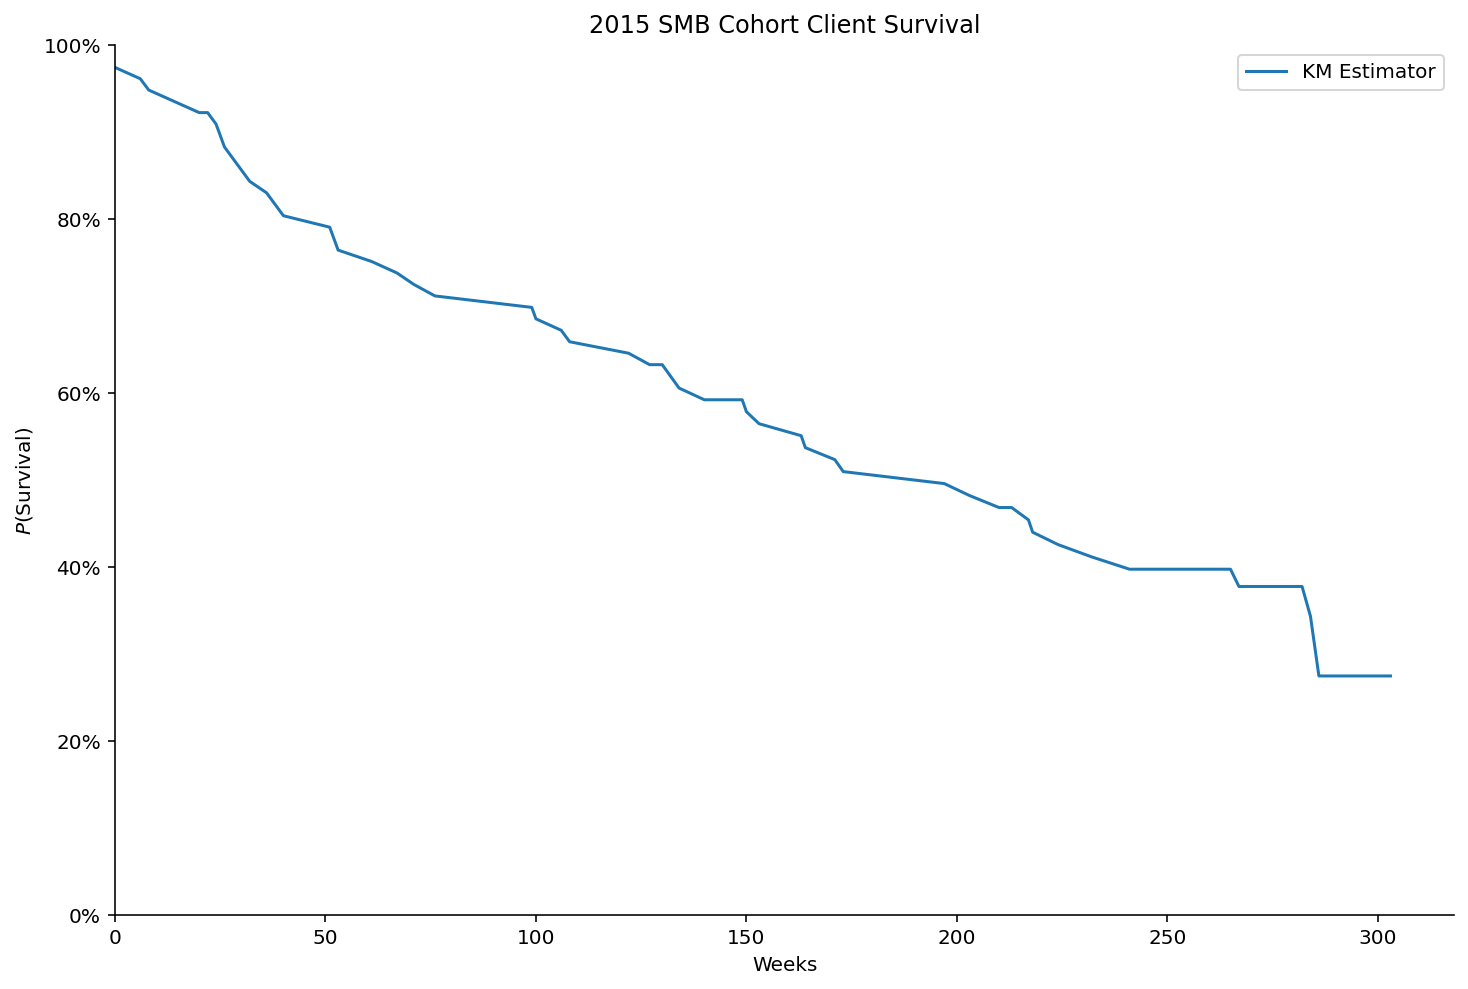

In [9]:
# Let's get the data we need
T = df['estimated_lifetime_weeks']
E = df['has_died']

# Let's construct a survival curve (non-parametric)
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# Now let's plot our survival curve
kmf.survival_function_.plot()
plt.title('2015 SMB Cohort Client Survival')
plt.ylim(0,1)
plt.xlim(left=0)
plt.ylabel('$P($Survival$)$')
plt.xlabel('Weeks')
plt.legend(['KM Estimator'])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

**Note**: See [this primer](https://docs.google.com/presentation/d/1RVoMneM1kYSb6_DazQG1m5PcWts5Qj5fpTKiZGvgCf4/edit?usp=sharing) JamesG put together on cohort survival analysis in the context of Flexport clients cohorted different ways. It's pretty good.

/Users/rdayabhai/venvs/da_prob_stat-mkU9H-Mw/lib/python3.7/site-packages/lifelines/plotting.py:667: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


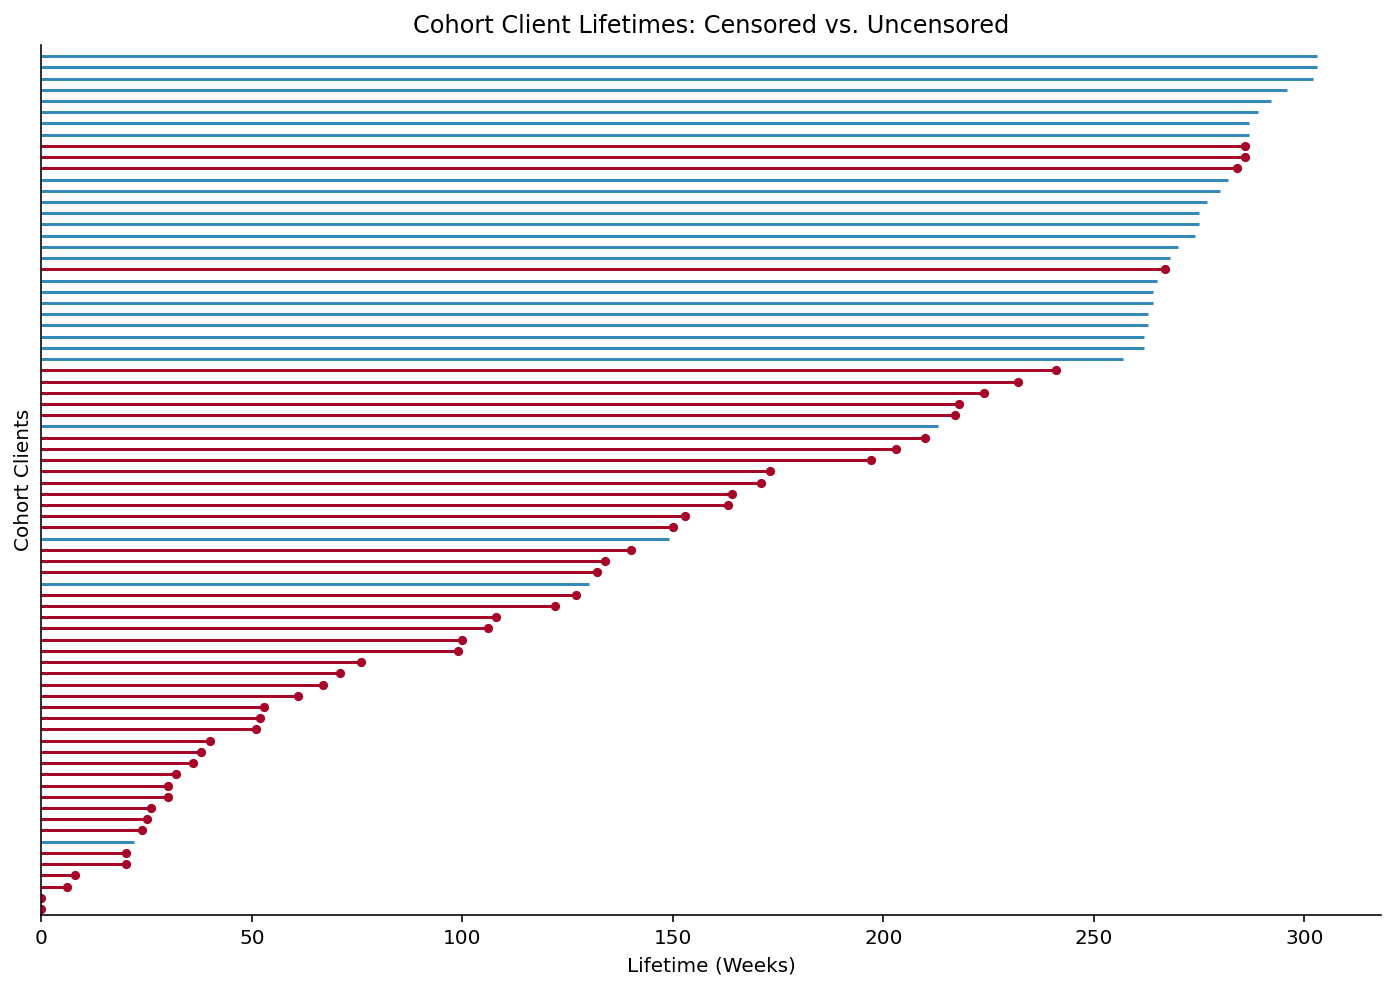

In [10]:
# Show censored vs. uncensored data
plot_lifetimes(T, event_observed=E)
plt.xlabel('Lifetime (Weeks)')
plt.ylabel('Cohort Clients')
plt.tick_params(
    axis='y',          
    which='both',      
    left=False,        
    labelleft=False)
plt.title('Cohort Client Lifetimes: Censored vs. Uncensored')
plt.show()

**Question**:

> How should I compute the expected or average lifetime of a client in this cohort?

#### Aside: Musician's Genre & Mortality 🎸 💀

We've been looking at the 2015 cohort of SMB clients in our applied example. In the same year, a pretty striking finding started trending on social media. 

**Upshot**: 

> Being a musician in **older musical genres** — blues, jazz, gospel — is a **relatively safe occupation**, whereas performing **new genres** — punk, metal, and especially rap and hip-hop — is **extraordinarily dangerous**.

This got picked up by a Washington Post [blog](https://www.washingtonpost.com/news/wonk/wp/2015/04/15/the-causes-of-musicians-deaths-by-genre/) and then featured on a [regular column](https://www.washingtonpost.com/news/morning-mix/wp/2015/03/25/over-half-of-dead-hip-hop-artists-were-murdered-study-finds/). The Washington Post, quoting the study's author Dianna Kenny as follows:

> "It's a cautionary tale to some degree," Kenny told the Washington Post. "People who go into rap music or hip hop or punk, they're in a much more occupational hazard profession compared to war. We don't lose half our army in a battle."

Wow. What a claim! **Someone should warn Chenga**, right?

![Genre & Death Misleading Chart](https://www.callingbullshit.org/case_studies/img/musician_mortality.jpeg)

![Genre & Death Misleading Table](https://www.callingbullshit.org/case_studies/img/musician_mortality_table.png)

**Question**: 

> What went wrong? 

Social media mischaracterized the original author's work because:

1. We have **right-censored data** 
2. A **conditional** statement being conflated with an **unconditional** statement.
3. The age-old data aphorism: **correlation does not imply causation**!

> ...it's not that rap stars will likely die young; it's that the rap stars *who have **already** died* certainly died young because rap hasn't been around long enough for it to be otherwise.

Source: [Calling Bullshit](https://www.callingbullshit.org/case_studies/case_study_musician_mortality.html). "Musicians and Mortality". 2017.

**Upshot**: Your ability to **think conditionally** about data is critical to your ability in interpreting it!

**Bonus Upshot**: In the same way the **data cannot speak for itself, nor can data viz speak for itself**! I beg of you: if you're making an argument that relies strongly or entirely on an infographic, please reconsider. 

#### Return: Modeling Cohort Churn

Okay, now we return to our regularly scheduled programming.

**Question**:

> How might I try to estimate the average probability $p$ of a client churning in a week? 

Note that $p$, the success probability, is the probability a client churns!

**Answer**:

> We could try to estimate some *parameter* $p$ that is the probability of churning each week where each week is a Bernoulli trial.

> In a given week, the retained clients all flip their ["churn" coins](https://docs.google.com/document/d/1__MwbwGsHC-IpkQiIDa-mIC5GQX_V588plw1Pv1kEJ8/edit#bookmark=id.eomwyzj76plj). The "churn" coin for a given client lands heads with probability $p$ and tails with probability $1-p$. A *success* as we've defined it here is a bad thing: it means a client has churned.

Notice the *isomorphism*!

Our **survival curve** from above tells us the **probability that a cohort client is still retained *at least* $t$ weeks after joining Flexport** (read: $P(\text{Survival})$ on the Y-axis).

**Question**:

> If I define $T$ to count the minimum number of weeks a cohort client is retained, how do I translate the above into probability notation using this random variable?

**Answer**:

> $P(T \geq t) = 1 - P(T \lt t) = 1 - P(T \leq t-1) = 1 - F_{T}(t-1)$

**Question**:

> What distribution might be a good candidate to help us figure out the average weekly probability $p$ of churn for cohort clients?

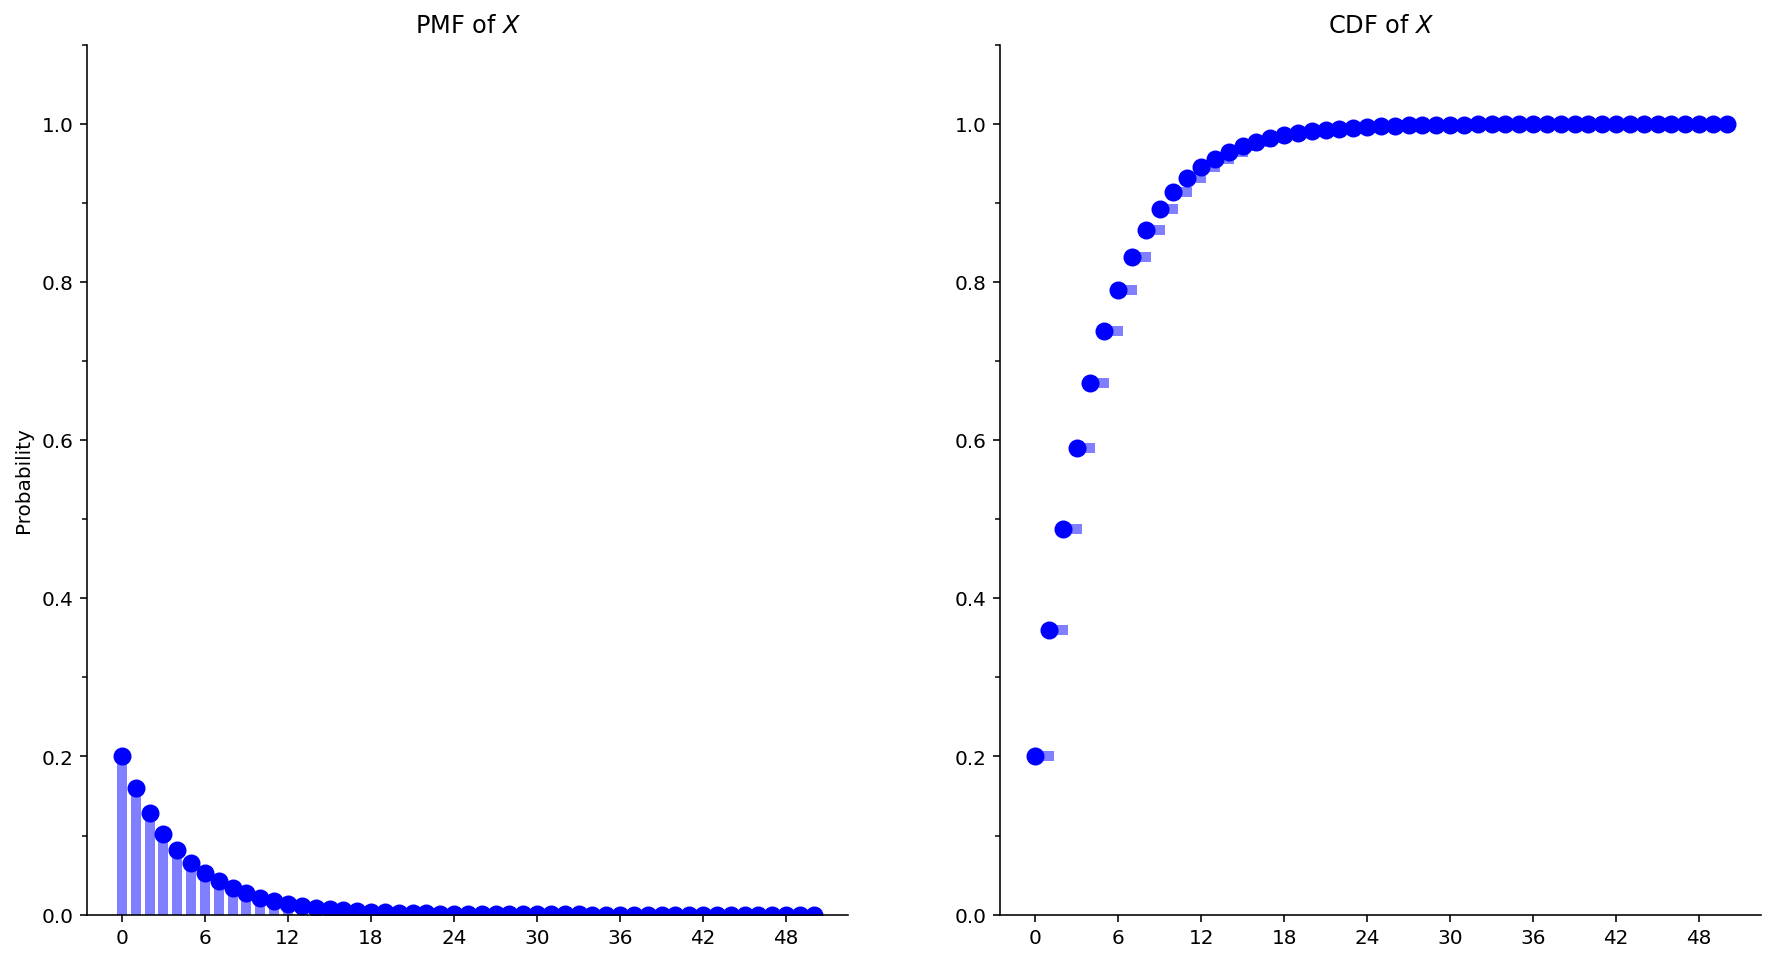

In [11]:
# Random variable X is distributed Geom(p)
p = .2
x = np.arange(0, 50+1)
pmf = geom.pmf(x, p, -1)
cdf = geom.cdf(x, p, -1)

# Plot
plot_distribution(x, pmf, cdf)

Take a look at the CDF of the Geometric. If seems like if we could **flip it upside down** (and shift it over slightly), it could be a good candidate to fit to our empirical survival curve!

It turns out that the **survival function** is defined for discrete distributions with non-negative, integer-valued supports as:

$$
G_{X}(x) = 1 - F_{X}(x) = 1 - P(X \leq x) = P(X \gt x)
$$

If we use the **first success** CDF (which is simply the offset Geometric's CDF), we should get what we're looking for!

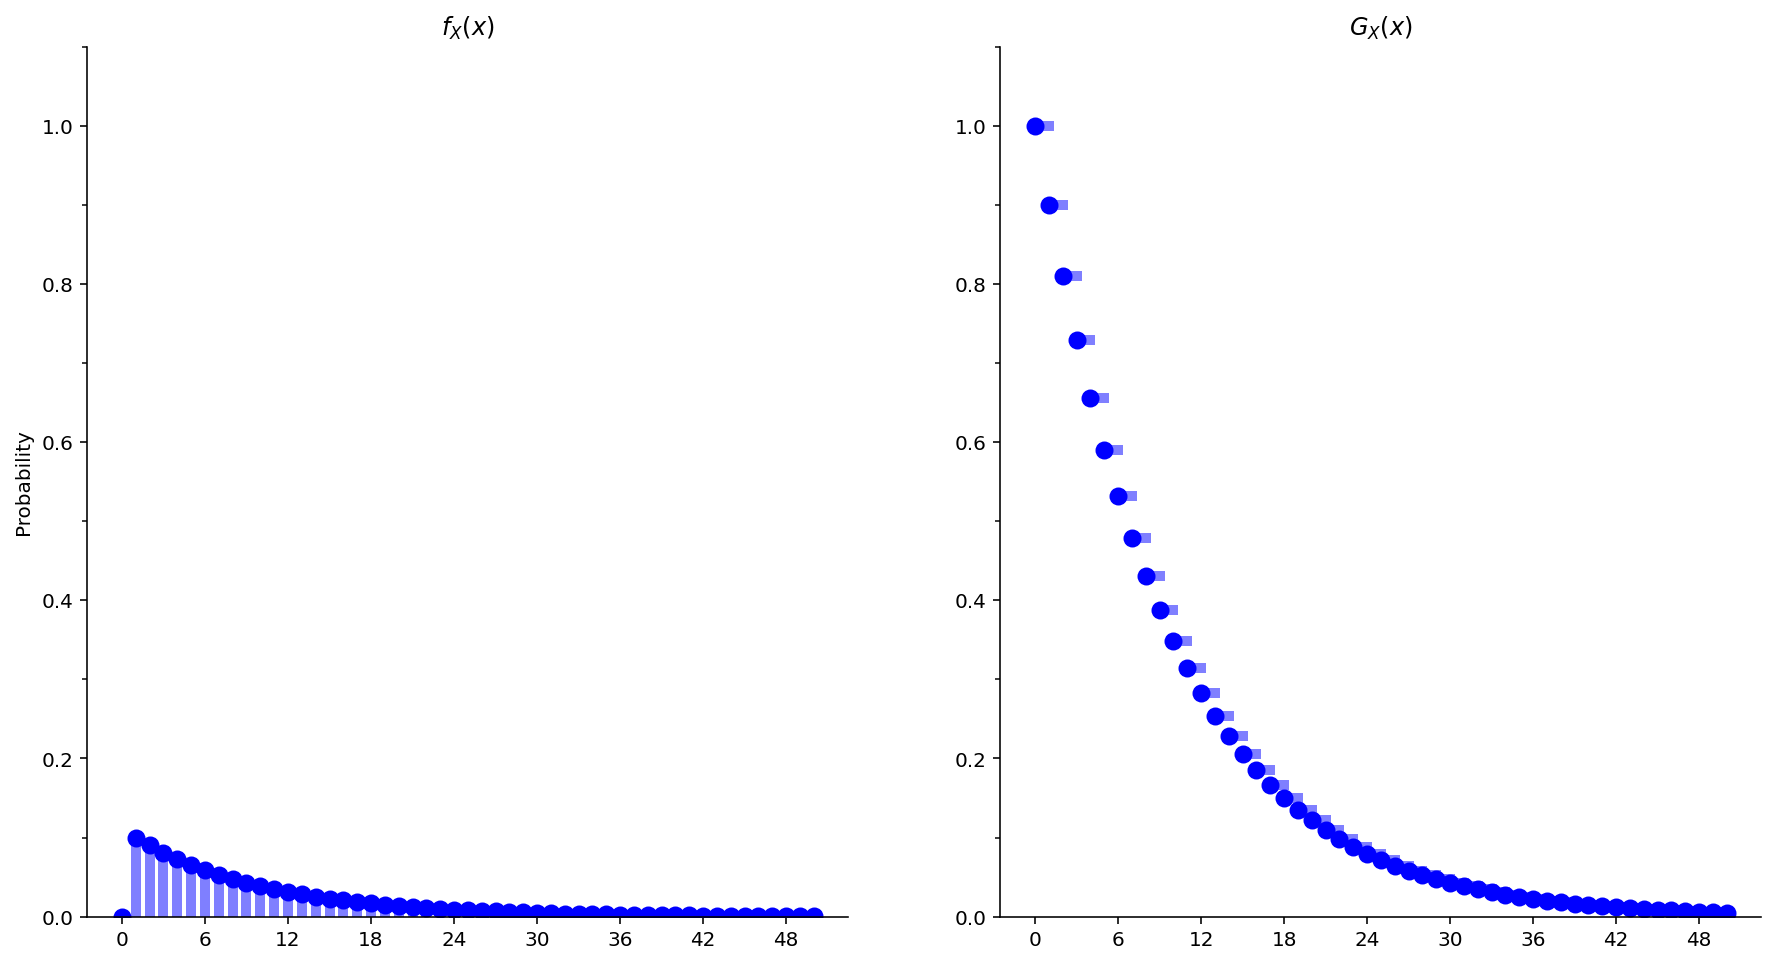

In [12]:
# Random variable X is distributed FS(p)
p = .1
x = np.arange(0, 50+1)
pmf = geom.pmf(x, p)
cdf = geom.cdf(x, p)

# Plot
plot_distribution(x, pmf, 1-cdf, ["$f_{X}(x)$", "$G_{X}(x)$"])

Since $\text{Geom}(p)$ is parameterized by one parameter, an estimate for $p$, which we'll call $\hat{p}$, is all we need to figure out.

**Question**:

> What does "best" fit mean, in terms of finding an estimate, $\hat{p}$ for parameter $p$?

**Answer**:

> Consider treating **$\hat{p}$ as a random variable**. Different choices of $\hat{p}$ will result in different models, and different models will result in different "fits" with respect to our data.

> Imagine our **data itself as a random variable**; taken together, let's call it $\mathcal{D}$.

> In order to find the "best" $\hat{p}$, we want to **maximize the likelihood** of seeing data like we have ($\mathcal{D}$) *given* a choice of $\hat{p}$; equivalently, we want to maximize $P(\mathcal{D} | \hat{p})$.

> Thus, we have established our **likelihood** function, $\mathcal{L}$,that we're looking to maximize:

$$
\mathcal{L}(\hat{p} | \mathcal{D}) = P(\mathcal{D} | \hat{p})
$$

For now, we're not going to dive deeply into **maximum-likelihood estimation**, but hopefully the intuition is there: we want to **turn the "dials and knobs" of our parameter(s)** until we find the parameter(s) that **maximize the likelihood of having observed the data we have on hand**. 

The parameters that do this define the model that fits best. This is called a **point estimate**. 

In [13]:
# Write loss function
def geom_neg_LL(p_hat, event_table):
    """
    Returns negative log-likelihood of Geometric distribution
    parameterized by p_hat, which is estimated via MLE.
    
    This should be *minimized* to find optimal p_hat.
    """
    censored_loss = geom.logpmf(event_table.index,
                                p_hat).dot(event_table['observed']).sum()
    uncensored_loss = geom.logsf(event_table.index,
                                 p_hat).dot(event_table['censored']).sum()
    LL = censored_loss + uncensored_loss
    return -LL

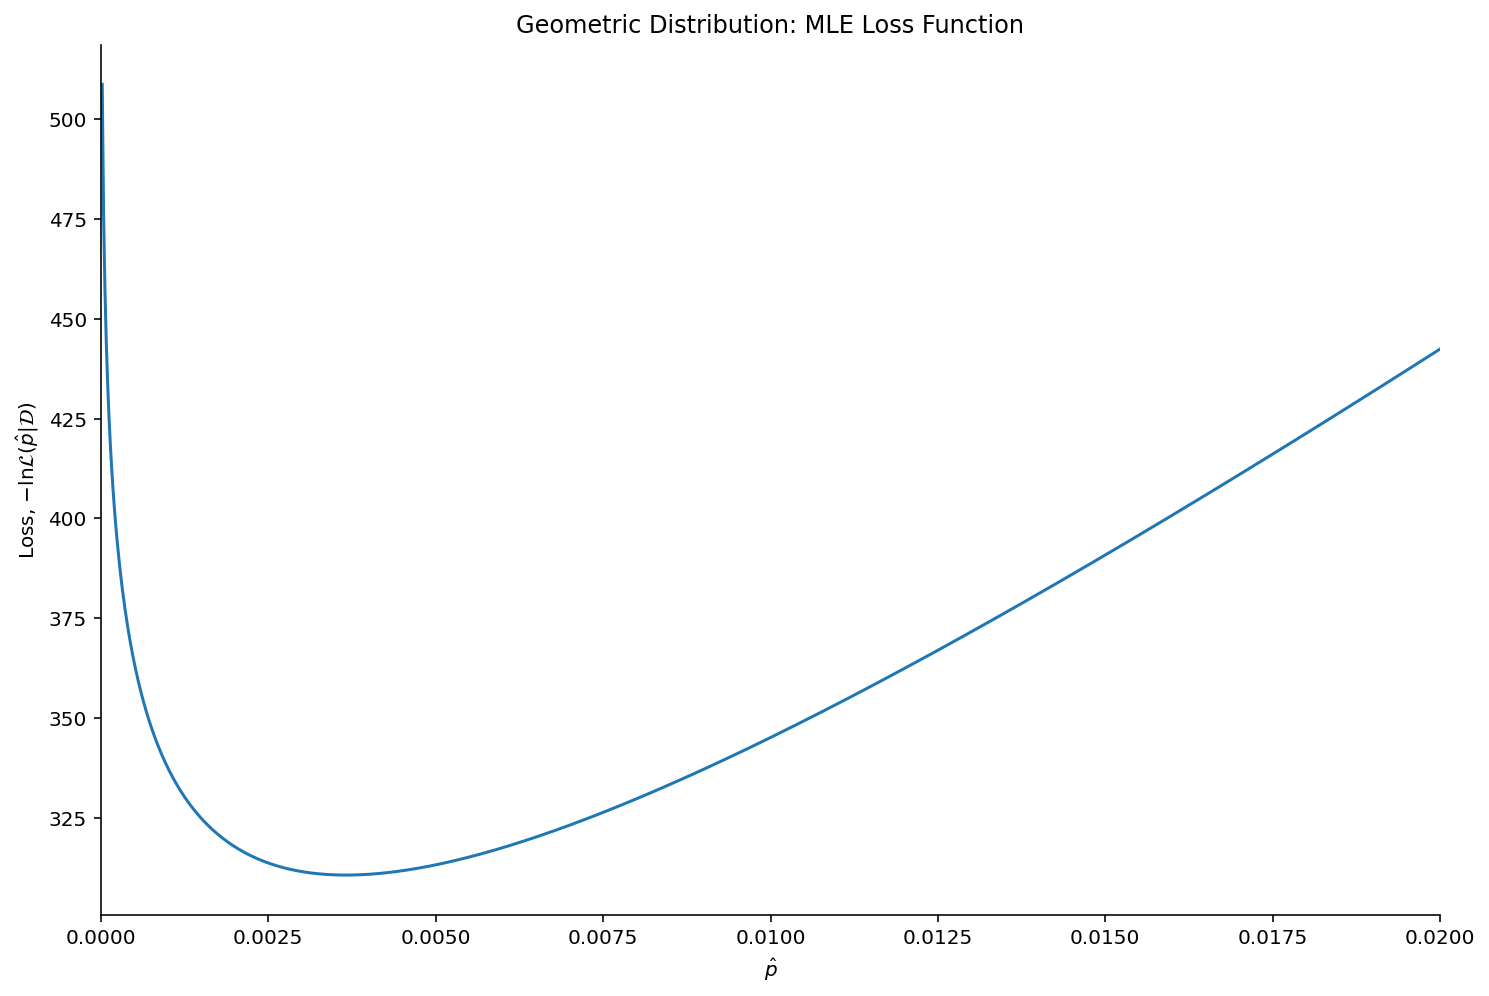

In [14]:
# Vectorize loss function
v_geom_neg_LL = np.vectorize(geom_neg_LL, excluded={1})

# Data to plot
x = np.linspace(0, 0.02, 1_000 + 1)
y = v_geom_neg_LL(x, kmf.event_table.iloc[1:,:])

# Plot loss function
plt.title('Geometric Distribution: MLE Loss Function')
plt.xlim(0, x.max())
plt.ylabel('Loss, $-\ln \mathcal{L}(\hat{p} | \mathcal{D})$')
plt.xlabel('$\hat{p}$')
plt.plot(x, y)
plt.show()

This should make it pretty clear as to what choice of $\hat{p}$ yields the best fit of our model to our data, $\mathcal{D}$ -- we just pick the $\hat{p}$ that minimizes our loss function!

Our estimate for p, p_hat, is 0.00366; this is our estimate for weekly churn risk!


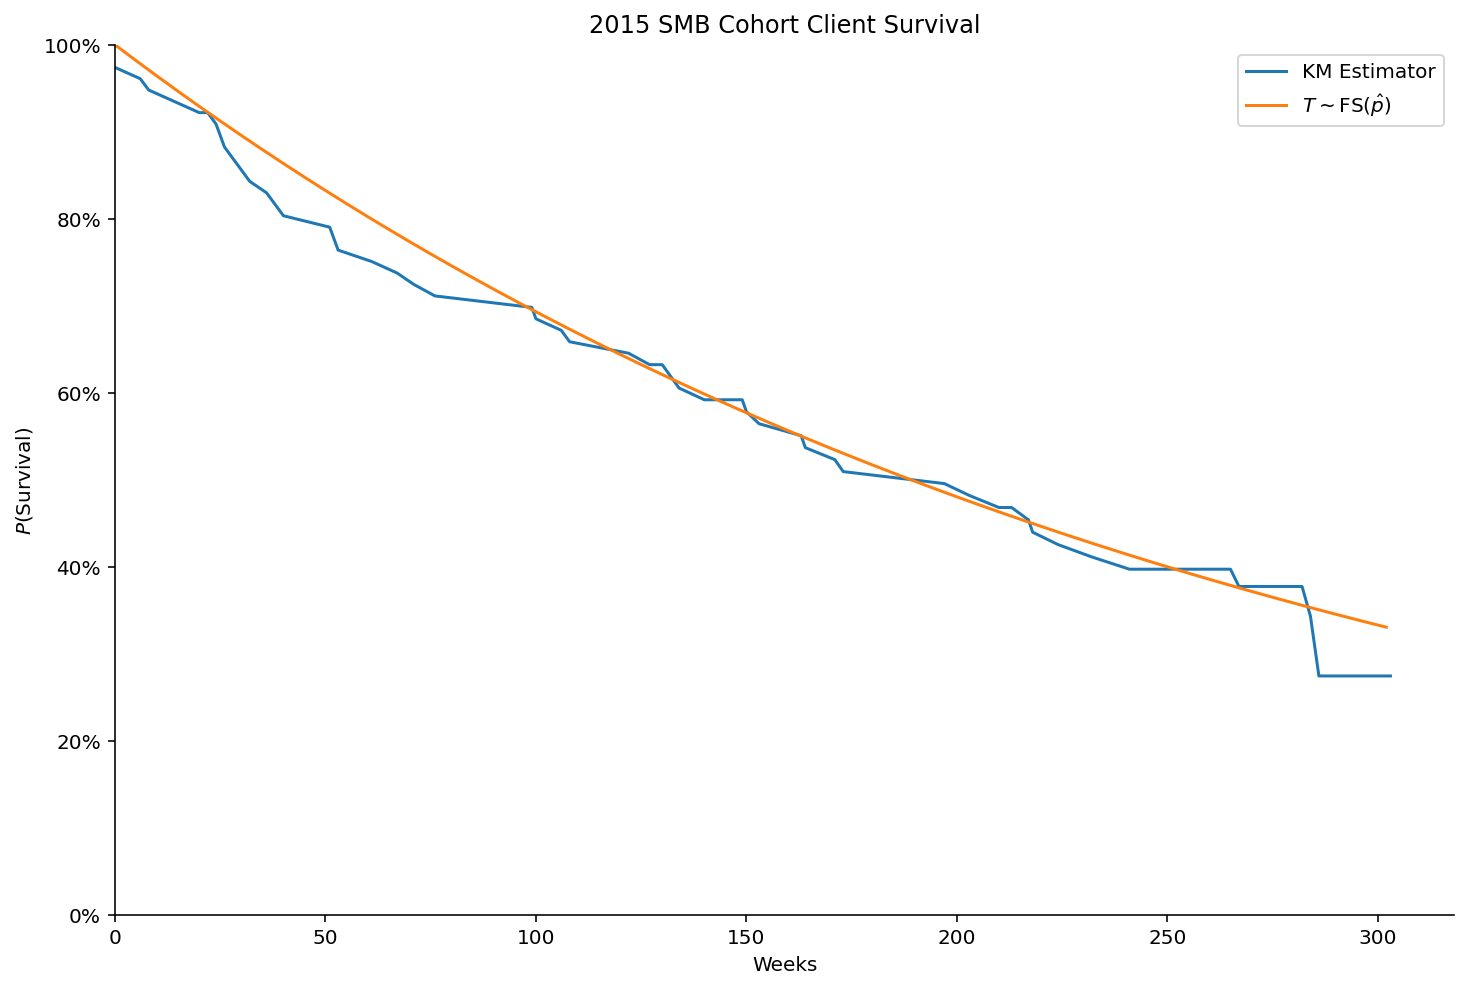

In [15]:
# Find argmin of loss function
loss_min = minimize_scalar(geom_neg_LL, 
                           bounds=(0,1), 
                           args=(kmf.event_table.iloc[1:,:]), 
                           method='bounded')
p_hat = loss_min.x
print(f"Our estimate for p, p_hat, is {p_hat:0.5f}; this is our estimate for weekly churn risk!")

# Reindex our survival probabilities
new_idx = pd.RangeIndex(0, kmf.survival_function_.index.max(), 1)

# Compare survival curve to FS(p_hat)
plt.rcParams["figure.figsize"] = (12,8)
kmf.survival_function_.plot()
plt.plot(geom.sf(new_idx, p_hat))
plt.title('2015 SMB Cohort Client Survival')
plt.ylim(0, 1)
plt.xlim(left=0)
plt.ylabel('$P($Survival$)$')
plt.xlabel('Weeks')
plt.legend(['KM Estimator', '$T \sim $FS$(\hat{p}$)'])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Remember my question about average lifetime of a cohort client?

With the **estimate of $p$, $\hat{p}$**, in hand, we can compute the **average client lifetime** for a cohort client as:

$$
\text{E}(T) = \frac{1 - p}{p}
$$

Note: This is the **expectation of the First Success**. The **expectation for the Geometric** is $\frac{1}{p}$. *This should intuitively make sense!*

In [16]:
# Estimate lifetime from expectation of fitted distribution
E_T = (1 - p_hat) / p_hat
print(f"Mean lifetime, from fitted distribution, is estimated to be {E_T:0.5f} weeks")

# We can also get median from our fitted distribution
m_T_param = geom.median(p_hat)
print(f"Median lifetime, from fitted distribution, is estimated to be {m_T_param:0.5f} weeks")

# Compared to the non-parametric estimate of median
m_T_non_param = kmf.median_survival_time_
print(f"Median lifetime, from Kaplan-Meier, is estimated to be {m_T_non_param:0.5f} weeks")

Mean lifetime, from fitted distribution, is estimated to be 272.24387 weeks
Median lifetime, from fitted distribution, is estimated to be 190.00000 weeks
Median lifetime, from Kaplan-Meier, is estimated to be 197.00000 weeks


We could ***not* estimate the average lifetime** by integrating under the Kaplan-Meier curve because we have **right-censored data** (i.e., have not witnessed all cohort clients churn yet).

By taking a **parametric approach**, we can reasonably estimate this statistic.

### The Memoryless Property 🎗

Let's a take a look at a unique feature that makes the Geometric special (...and worth *remembering* 😉).

> A discrete distribution is said to have **memorylessness** if

$$
\forall s, t \in \{0, 1, 2, ...\},\ P(X \geq s + t | X \geq t) = P(X \geq s)
$$

> for a random variable $X$ distributed according to that distribution.

Don't let this notation scare you -- it is merely formalizing a really simple idea by leveraging what we know about conditional events.

Let's take this piece-by-piece:

$$
\forall s, t \in \{0, 1, 2, ...\},\ P(X \geq s + t | X \geq t) = P(X \geq s)
$$

Let's say a client has been retained for at least $t$ weeks (e.g., 10 weeks, for concreteness). Given this fact (this is the $P(...|X \geq t)$ bit), the **probability the client will stay retained for at least $s$ additional weeks** (e.g., 6 weeks for concreteness; this is the $P(X \geq s + t |...)$) **is the same as the probability the client had been retained for at least $s$ weeks** (i.e., the right-hand side: $P(X \geq s)$).

Another way to think about this, is using the simple "story" of the Geometric:

Suppose you walk into the room while someone is flipping the coin. How do you know how many flips have occurred before you came in, and **why would it matter**? 

The distribution would be exactly the same regardless of the past. Tying this back to our client retention example, **it's as if the distribution "forgot" about a client's "life" having been at least $t$ weeks already**!

We could prove this algebraically, but I think a more powerful, intuitive understanding comes from looking at the picture of the PMF:

![Memoryless Illustration](https://miro.medium.com/max/1400/1*qL_TTzoAy7K9r2Kxb-XCpA.png)

In fact, the above picture is of the **Exponential** distribution, the continuous cousin of the Geometric, but the intuition is the same (the Exponential is the only continuous distribution that has memorylessness).

## The Poisson 🐟

Revisiting what I talked about at the tail-end of 📚.3.2:

> So far, we've only considered static number of trials and probabilities of success for each trial. Allowing these to go to some *limit*, we can begin to model much more interesting phenomena.

> Consider a port, and we define a random variable, $X$, to count the the number of vessels carrying Flexport containers that arrive each hour in a day. (How would we compute the average number of Flexport-laden vessels?)

> Now, let $Y$ count the same thing as $X$ except that now we're counting every minute. The probability we see any given vessel of interest is smaller in this given interval, right?

> What about $Z$ that does the same as the other random variables, but for every nanosecond? The pattern should hold, right? In any given nanosecond, it's very, very unlikely a boat we're looking to count will come through. 

**Question**:

> What happens when I begin to do Bernoulli trials "faster and faster" with the probability of each trial getting proportionally smaller and smaller?

**Hint 1**: Start with $X\sim\text{Bin}(n, p)$. Now increase $n$ and decrease $p$ such that $\lambda$ stays constant (where $\lambda = np$).

**Hint 2**: Try to simulate this -- what do you notice? **Submit a PR!**

**Hint 3**: Watch the last 10 minutes of our lesson on [Derangements](https://drive.google.com/file/d/1NBG5lqpSOa6JR5mUkNSx0qzhnUltZ39l/view?usp=sharing).

**Answer**:

> We're actually beginning to blur the line between:
>
> 1. counting whether or not a success happened in **one, discrete step** (i.e., a Bernoulli trial) and adding up these successes over $n$ steps (i.e., the story of the Binomial) and
> 2. counting the number of successes over ***one* continuous interval** (i.e., $\lambda$), where the interval is made up of more and more ($n \to \infty$) of these ever smaller discrete steps

We can now see why $\lambda$ is called a **rate parameter**: it counts how often the thing of interest we're counting happens over some (fixed) interval of time.


In the same way that the **Hypergeometric** taken to the limit (under constant $p = \frac{w}{w+b}$ as $w+b \to \infty$) is the **Binomial**, the **Binomial** taken to its limit (under $np \to \lambda$) is the **Poisson**!

![Discrete Distribution Relationships](./discrete_distribution_links.png)

We won't actually [prove this fact](https://en.wikipedia.org/wiki/Poisson_limit_theorem), but the **PMF of the Poisson** is the limiting case of the binomial:

> Let $X \sim \text{Pois}(\lambda)$. Then the PMF of $X$ is given by:

$$
f_{X}(k) = P(X=k) = \lim_{n\to \infty }{n \choose k}p^{k}(1-p)^{n-k}=e^{-\lambda }{\frac {\lambda ^{k}}{k!}}
$$

> for $\lambda \gt 0$ and $k = 0, 1, 2, ...$

The Poisson is one of the most important named distributions and often the default choice when modeling frequencies of occurences (of whatever we're interested in).

- number of queuing customers at grocery store checkout in 10 minutes
- number of radioactive particles that decay over a century
- number of chocolate chips in a $4\pi\, \text{in}^{2}$ chocolate chip cookie
- number of raindrops that fall on a sheet of 8.5" x 11" paper laid outside
- number of COVID-19 virions in an $6 \times 10^{8}\, \text{mL}$ aerosol particle

**Question**:

> If $X \sim \text{Pois}(\lambda)$, what is $E(X)$?

**Answer**:

> Use the **definition of expectation** and notice the **Taylor series approximation for $e^{\lambda}$**:

$$
\begin{align}
E(X) = \sum_{x=0}^{\infty} x {\frac {e^{-\lambda} \lambda ^{x}}{x!}} &= e^{-\lambda} \sum_{x=0}^{\infty} x {\frac {\lambda ^{x}}{x!}}\\
     &= e^{-\lambda} \sum_{x=1}^{\infty} x {\frac {\lambda ^{x}}{x!}}\\
     &= e^{-\lambda} \sum_{x=1}^{\infty} {\frac {\lambda ^{x}}{(x-1)!}}\\
     &= e^{-\lambda}\lambda \sum_{x=1}^{\infty} {\frac {\lambda ^{x-1}}{(x-1)!}}\\
     &= e^{-\lambda}\lambda \sum_{x=0}^{\infty} {\frac {\lambda ^{x}}{x!}}\\
     &= e^{-\lambda}\lambda e^{\lambda}\\
     &= \lambda
\end{align}
$$


What's particularly interesting (and convenient) about the Poisson is that the variance of the Poisson is also $\lambda$!

$$
\text{E}(X) = \text{Var}(X) = \lambda
$$

If you don't believe me, prove it \[to yourself\]!